# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [3]:
!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

mkdir: cannot create directory ‘cifar10’: File exists
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
tar: cifar-10-batches-py: Cannot utime: Operation not permitted
tar: cifar-10-batches-py: Cannot change mode to rwxr-xr-x: Operation not permitted
tar: Exiting with failure status due to previous errors


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

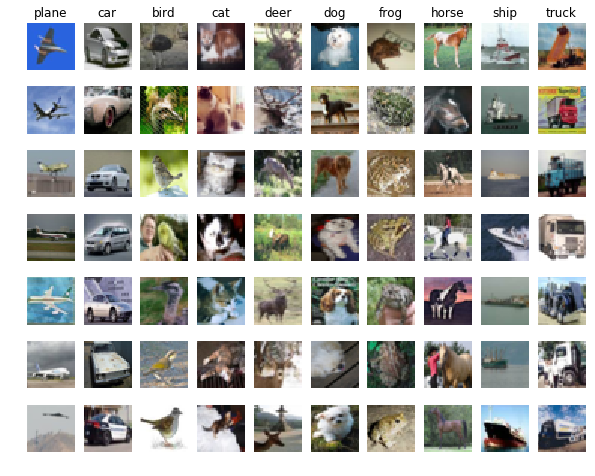

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X",dtype='float32')
target_y = T.vector("target Y integer",dtype='int32')

/home/igor/anaconda2/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [5]:
width=5
drop=0.3

In [6]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
net = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(net, 16, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
#split1
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(net, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)

branch_right = lasagne.layers.Conv2DLayer(net, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)


#merge1
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split2

branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = branch_left = lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net

#merge2
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split3

branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = branch_left = lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net

#merge3
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split4

branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 16*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net

#merge4
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net, nonlinearity=lasagne.nonlinearities.rectify)
net = lasagne.layers.dropout(branch_left, p = drop)
#split5
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(net, 32*width, filter_size=(3,3), stride=(2,2), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = lasagne.layers.Conv2DLayer(net, 32*width, filter_size=(3,3), stride=(2,2), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
#merge5
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split6
branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net
#merge6
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split7
branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net
#merge7
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split8
branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 32*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net
#merge8
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net, nonlinearity=lasagne.nonlinearities.rectify)
net = lasagne.layers.dropout(branch_left, p = drop)
#split9
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(net, 64*width, filter_size=(3,3), stride=(2,2), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = lasagne.layers.Conv2DLayer(net, 64*width, filter_size=(3,3), stride=(2,2), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
#merge9
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split10
branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net
#merge10
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split11
branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p=drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net
#merge11
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
#split12
branch_left = lasagne.layers.BatchNormLayer(net)
branch_left = lasagne.layers.NonlinearityLayer(branch_left, nonlinearity=lasagne.nonlinearities.rectify)
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=lasagne.nonlinearities.rectify))
branch_left = lasagne.layers.dropout(branch_left, p = drop)
branch_left = lasagne.layers.Conv2DLayer(branch_left, 64*width, filter_size=(3,3), pad=1, W=lasagne.init.GlorotUniform(), 
                                 nonlinearity=None)
branch_right = net
#merge12
net = lasagne.layers.ElemwiseMergeLayer([branch_left, branch_right], merge_function=theano.tensor.add)
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net, nonlinearity=lasagne.nonlinearities.rectify)
net = lasagne.layers.Pool2DLayer(net, pool_size=(8,8), mode='average_exc_pad', stride=(1,1), pad=(4,4))
net = lasagne.layers.FlattenLayer(net, outdim=2)
print(lasagne.layers.get_output_shape(net))
print(lasagne.layers.get_output_shape(branch_left))
print(lasagne.layers.get_output_shape(branch_right))
net = lasagne.layers.DenseLayer(net, num_units = 10, nonlinearity=softmax)

(None, 25920)
(None, 320, 8, 8)
(None, 320, 8, 8)


In [7]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, beta, gamma, W, b, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, W, beta, gamma, W, b, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, W, beta, gamma, W, b, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, b]


In [8]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y)
loss = loss.mean() + 0.0000005*lasagne.regularization.regularize_layer_params(lasagne.layers.get_all_layers(net), lasagne.regularization.l2)
test_prediction = lasagne.layers.get_output(net, deterministic=True)
accuracy = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_y),
                  dtype=theano.config.floatX)

In [9]:
updates = lasagne.updates.nesterov_momentum(
        loss, all_weights, learning_rate=0.01, momentum=0.9)

In [10]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [11]:

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [ ]:
import time



num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size, augment=True):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Kholopov.log", "a+") as f:
        f.write("Epoch {} of {} took {:.3f}s\n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f}\n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} %\n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} %\n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

/home/igor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


Epoch 1 of 10 took 665.411s
  training loss (in-iteration):		0.391905
  train accuracy:		87.59 %
  validation accuracy:		84.65 %
Epoch 2 of 10 took 665.634s
  training loss (in-iteration):		0.374541
  train accuracy:		88.34 %
  validation accuracy:		84.66 %
Epoch 3 of 10 took 665.704s
  training loss (in-iteration):		0.357106
  train accuracy:		89.05 %
  validation accuracy:		85.11 %
Epoch 4 of 10 took 665.535s
  training loss (in-iteration):		0.343418
  train accuracy:		89.60 %
  validation accuracy:		85.25 %
Epoch 5 of 10 took 665.708s
  training loss (in-iteration):		0.326250
  train accuracy:		89.92 %
  validation accuracy:		85.22 %
Epoch 6 of 10 took 665.590s
  training loss (in-iteration):		0.312841
  train accuracy:		90.68 %
  validation accuracy:		85.05 %
Epoch 8 of 10 took 665.859s
  training loss (in-iteration):		0.285749
  train accuracy:		91.52 %
  validation accuracy:		86.22 %


In [20]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		86.73 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 